In [1]:
import os
import pickle
import numpy as np
import mdtraj as md
import pyemma
from deeptime.clustering import KMeans
from deeptime.decomposition import TICA
from deeptime.markov.tools import estimation
import alphashape
from shapely.geometry import Polygon
from scipy.interpolate import CubicSpline

In [2]:
def smooth_polygon_vertices(vertices, smoothness=100):
    if not np.array_equal(vertices[0], vertices[-1]):
        vertices = np.vstack([vertices, vertices[0]])
    dists = np.sqrt(np.sum(np.diff(vertices, axis=0)**2, axis=1))
    dists = np.insert(dists, 0, 0)
    cum_dists = np.cumsum(dists)
    cum_dists /= cum_dists[-1]
    cs_x = CubicSpline(cum_dists, vertices[:, 0], bc_type='periodic')
    cs_y = CubicSpline(cum_dists, vertices[:, 1], bc_type='periodic')
    smooth_dists = np.linspace(0, 1, smoothness)
    return np.vstack([cs_x(smooth_dists), cs_y(smooth_dists)]).T

def plot_cluster_shape(data, alpha_val):
    alpha_shape = alphashape.alphashape(data, alpha_val)
    if isinstance(alpha_shape, Polygon):
        polygon_points = np.array(alpha_shape.exterior.coords)
    else:
        polygon_points = np.array(list(alpha_shape.geoms)[0].exterior.coords)
    smooth_points = smooth_polygon_vertices(polygon_points, smoothness=200)
    return smooth_points

def feature(dirs, pdb, cutoff=0.8):
    feat = pyemma.coordinates.featurizer(pdb)
    pairs = feat.pairs(feat.select_Ca())
    feat.add_contacts(pairs,threshold=cutoff)
    data = pyemma.coordinates.source(dirs, features=feat)
    data_output = data.get_output()
    return data_output

def cluster(feature,n_clusters=400):
    from sklearn.cluster import MiniBatchKMeans
    kmeans = MiniBatchKMeans(n_clusters=n_clusters,random_state=0,batch_size=2048,n_init="auto",max_iter=200)
    first_dim = feature.shape[0]
    trans_data = feature.reshape(first_dim,-1)
    kmeans = kmeans.partial_fit(trans_data)
    cluster_labels = kmeans.labels_
    return cluster_labels

In [3]:
intervals = [400, 400, 400, 400, 400, 800]
replicas = [16, 16, 16, 16, 16, 16]
lagtimes = [40, 40, 40, 40, 40, 80]

In [4]:
# load native states dirs
native_pdbs = []
native_dcds = []
protein_lst = ['1fme', '2f4k', '2f21', '2hba', '2p6j', '2a3d']
for i,protein_name in enumerate(protein_lst):
    native_pdbs.append('./iTOL_plot/'+protein_name+'/p.pdb')
    native_dcds.append('./iTOL_plot/'+protein_name+'/p.dcd')
    native_pdb = md.load_pdb(native_pdbs[i])
    native_pdb.save('./iTOL_plot/'+protein_name+'/p.dcd')
    
native_outs = []
for pdb,dcd in zip(native_pdbs,native_dcds):
    native_outs.append(feature(dcd,pdb))

#### If no data saved

In [8]:
AC_lens = []
LC_lens = []
all_tics = []

for i,protein_name in enumerate(protein_lst):
    if i==5:
        stride = 10
    else:
        stride = 1
    with open('./data/'+protein_name+'/data_output.pkl', 'rb') as f:
        AC_data = pickle.load(f)
    with open('../least_count/'+protein_name+'/data_output.pkl', 'rb') as f:
        LC_data = pickle.load(f)
    tica_estimator = TICA(lagtime=lagtimes[i], dim=2)
    AC = np.concatenate(np.array(AC_data),axis=0)
    LC = np.concatenate(np.array(LC_data),axis=0)
    
    del AC_data, LC_data
    
    all_out = np.concatenate((AC,LC),axis=0)
    all_out = np.concatenate((all_out,native_outs[i][0]),axis=0)
    tica = tica_estimator.fit(all_out[::stride]).fetch_model()
    print('TICA dimension = ', tica.output_dimension)
    tics = tica.transform(all_out)
    all_tics.append(tics)
    
    AC_lens.append(AC.shape[0])
    LC_lens.append(LC.shape[0])
    
    del AC, LC, all_out, tics

TICA dimension =  2
TICA dimension =  2
TICA dimension =  2
TICA dimension =  2
TICA dimension =  2
TICA dimension =  2


In [6]:
smooth_points = []
for i, pro in enumerate(protein_lst):
    A = plot_cluster_shape(all_tics[i][:AC_lens[i]],2)
    B = plot_cluster_shape(all_tics[i][LC_lens[i]:-1],2)
    smooth_points.append([A,B])

In [12]:
n_clusters = 20000
zeta_CVgen = []
zeta_least = []
n_rounds_lst = []
for i,tics in enumerate(all_tics):
    zeta_AC = []
    zeta_LC = []
    nframes_per_round = intervals[i] * replicas[i]
    tot_rounds = np.min([AC_lens[i]//nframes_per_round,LC_lens[i]//nframes_per_round])
    n_rounds_lst.append(tot_rounds)
    sel_tics = np.append(tics[:tot_rounds*nframes_per_round],tics[AC_lens[i]:AC_lens[i]+tot_rounds*nframes_per_round],axis=0)
    cluster_labels = cluster(sel_tics,n_clusters=n_clusters)
    
    for j in range(tot_rounds):
        end = (j+1)*nframes_per_round
        CVgen_end = end
        least_end = end
            
        CVgen_labels = cluster_labels[:CVgen_end]
        least_labels = cluster_labels[tot_rounds*nframes_per_round:tot_rounds*nframes_per_round+least_end]
        zeta_AC.append(np.unique(CVgen_labels).shape[0]/np.unique(cluster_labels).shape[0])
        zeta_LC.append(np.unique(least_labels).shape[0]/np.unique(cluster_labels).shape[0])
    zeta_CVgen.append(zeta_AC)
    zeta_least.append(zeta_LC)

In [13]:
with open('AC_lens.pkl','wb') as f:
    pickle.dump(AC_lens,f)
with open('N_rounds_lst.pkl','wb') as f:
    pickle.dump(n_rounds_lst,f)
with open('all_tics_AC_LC.pkl','wb') as f:
    pickle.dump(all_tics,f)
with open('smooth_points_AC_LC.pkl','wb') as f:
    pickle.dump(smooth_points,f)
with open('zeta_CVgen.pkl','wb') as f:
    pickle.dump(zeta_CVgen,f)
with open('zeta_least.pkl','wb') as f:
    pickle.dump(zeta_least,f)

#### If data saved

In [5]:
with open('AC_lens.pkl','rb') as f:
    AC_lens = pickle.load(f)
with open('N_rounds_lst.pkl','rb') as f:
    n_rounds_lst = pickle.load(f)
with open('all_tics_AC_LC.pkl','rb') as f:
    all_tics = pickle.load(f)
with open('smooth_points_AC_LC.pkl','rb') as f:
    smooth_points = pickle.load(f)
with open('zeta_CVgen.pkl','rb') as f:
    zeta_CVgen = pickle.load(f)
with open('zeta_least.pkl','rb') as f:
    zeta_least = pickle.load(f)

In [6]:
letter_size = 24
label_size = 22
lengend_size = 20

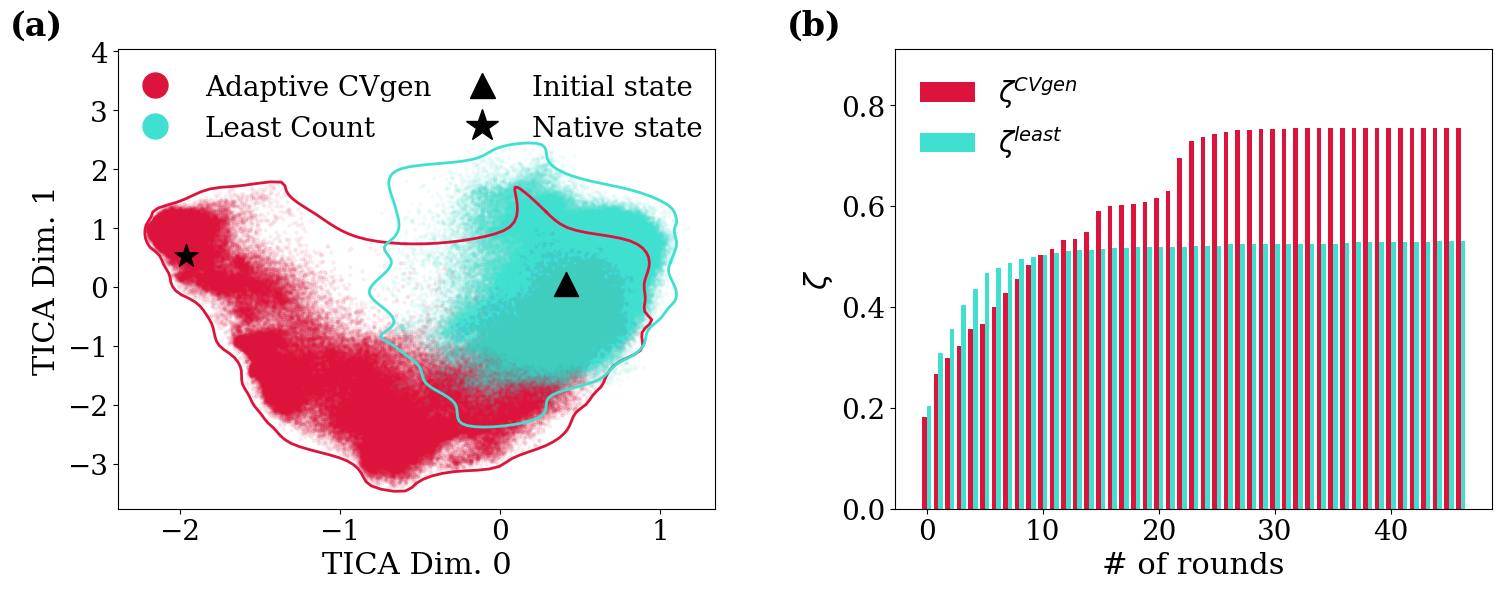

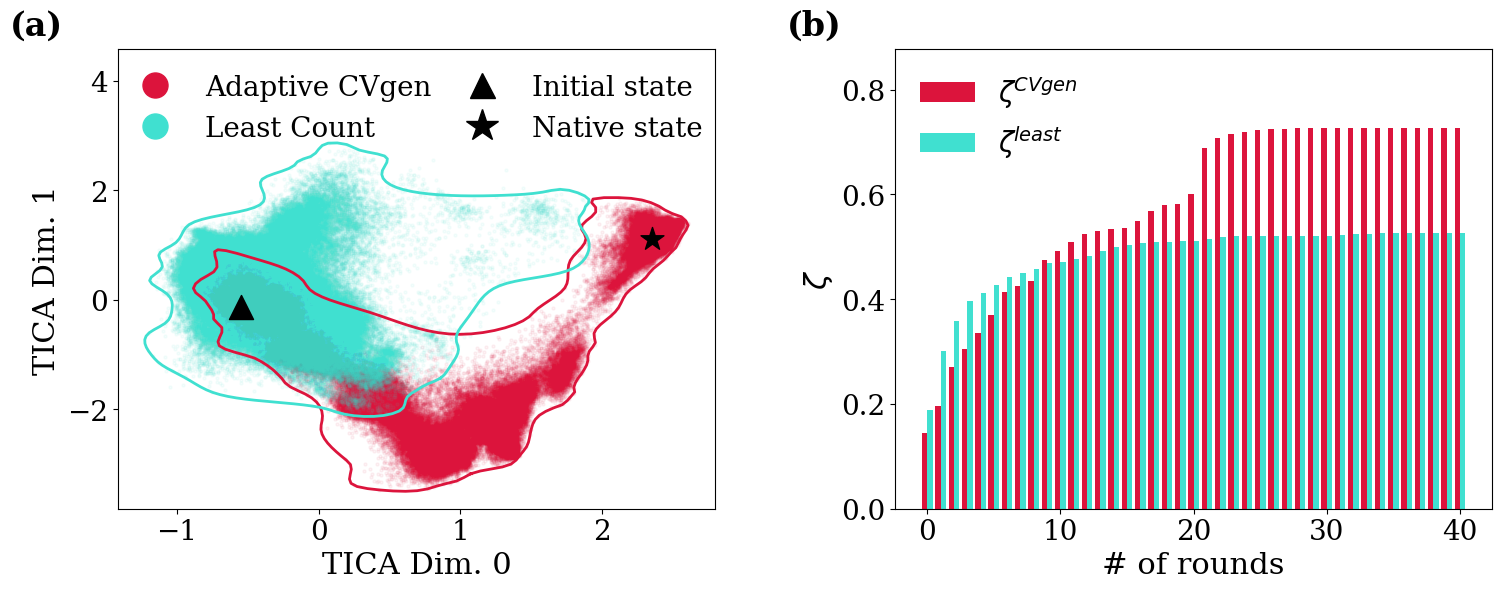

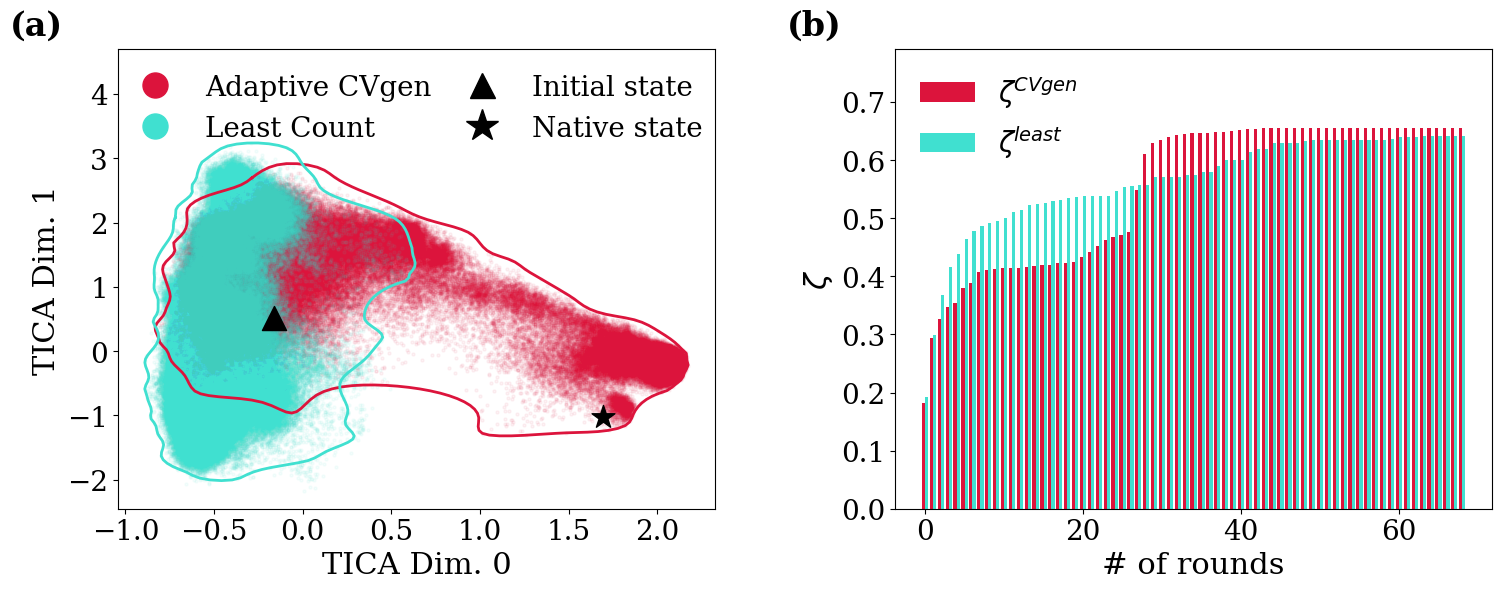

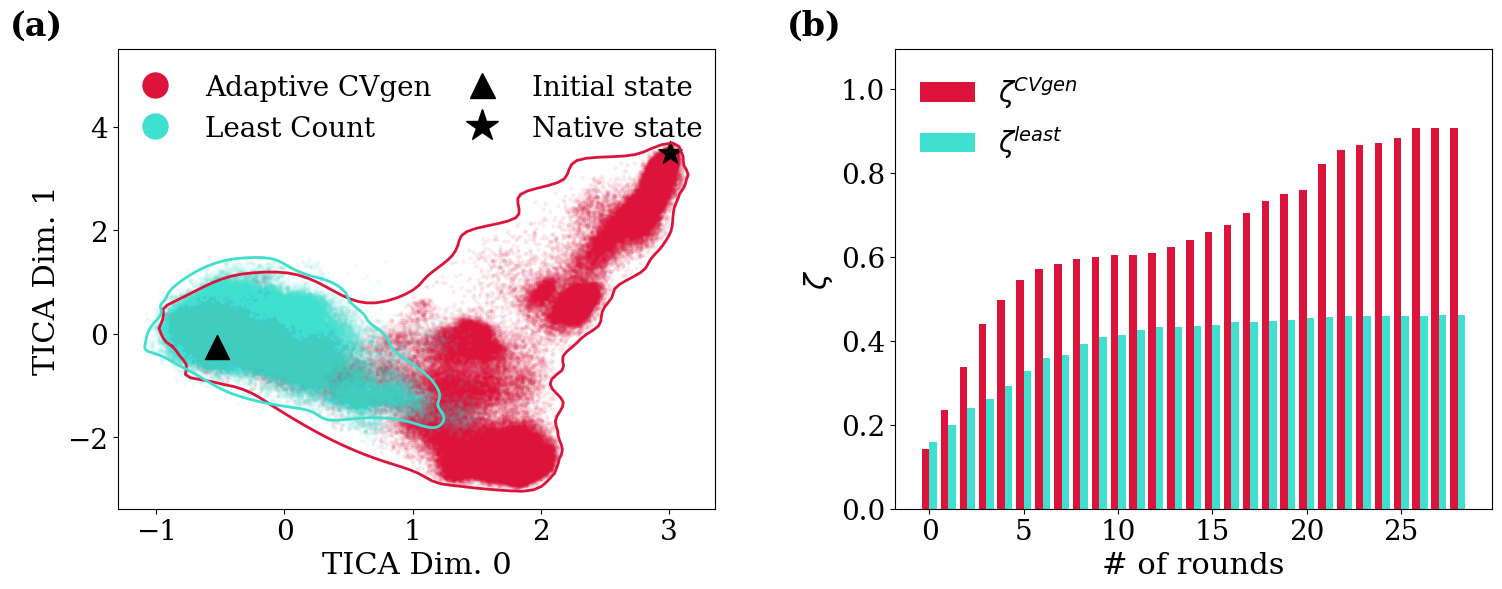

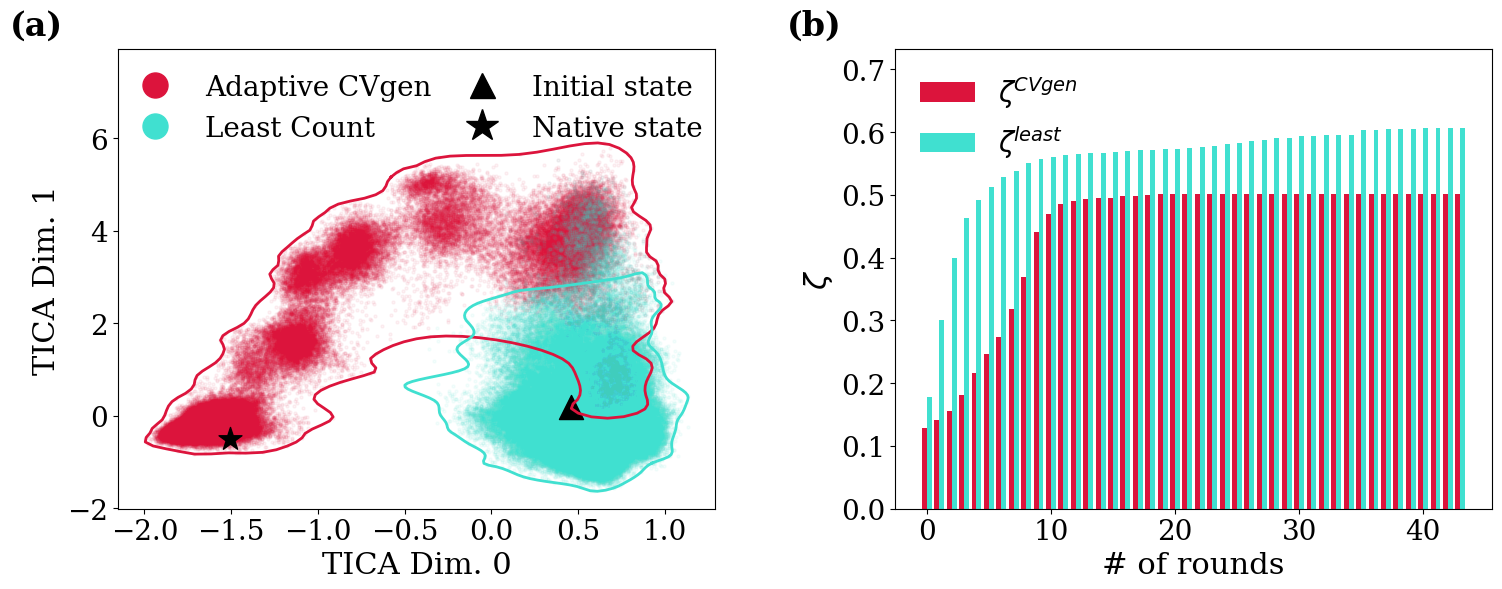

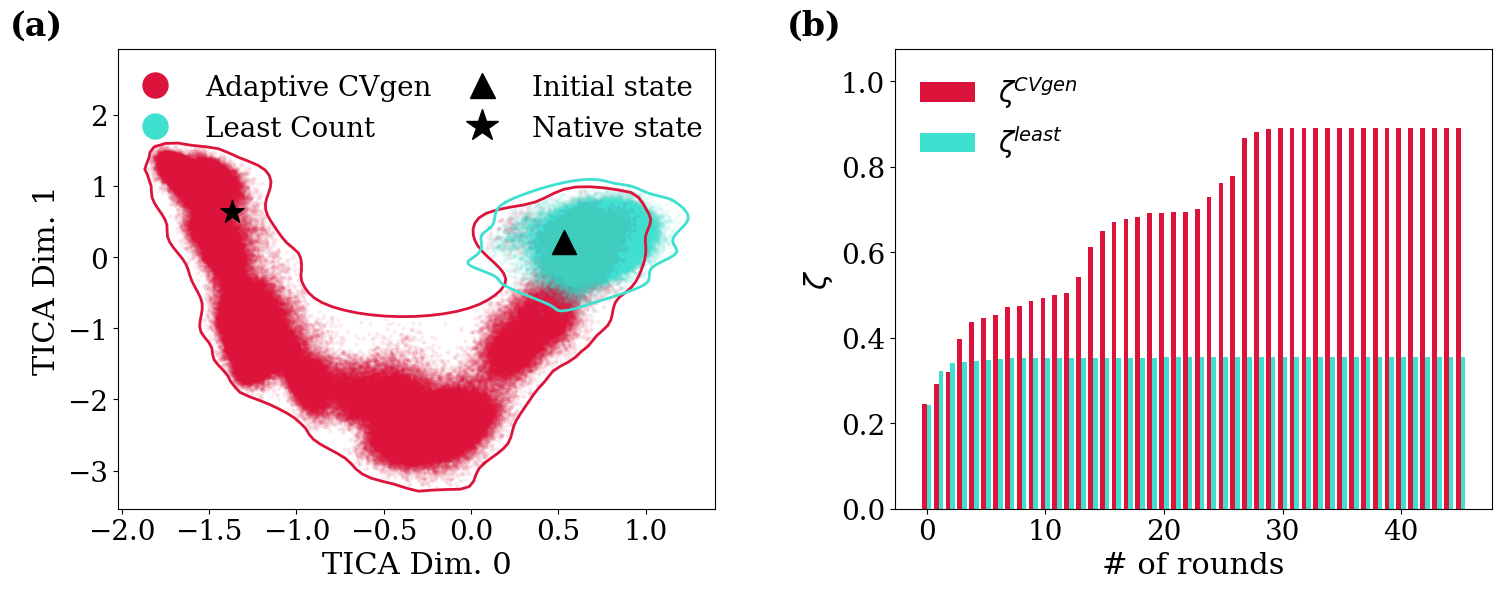

In [9]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams["font.family"] = "serif"
for th_num_pro in range(6):
    # Create a grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Add labels to each subplot
    axs[0].text(-0.18, 1.03, "(a)", transform=axs[0].transAxes, fontsize=letter_size, fontweight='bold')
    axs[1].text(-0.18, 1.03, "(b)", transform=axs[1].transAxes, fontsize=letter_size, fontweight='bold')

    axs[0].scatter(all_tics[th_num_pro][:AC_lens[th_num_pro],0], all_tics[th_num_pro][:AC_lens[th_num_pro],1], label='Adaptive CVgen', c='Crimson', s=5, alpha=0.05)
    # 绘制平滑的轮廓线
    axs[0].plot(smooth_points[th_num_pro][0][:, 0], smooth_points[th_num_pro][0][:, 1], color='Crimson', linewidth=2)

    axs[0].scatter(all_tics[th_num_pro][AC_lens[th_num_pro]:-1,0], all_tics[th_num_pro][AC_lens[th_num_pro]:-1,1], label='Least Count', c='Turquoise', s=5, alpha=0.05)
    # 绘制平滑的轮廓线
    axs[0].plot(smooth_points[th_num_pro][1][:, 0], smooth_points[th_num_pro][1][:, 1], color='Turquoise', linewidth=2)

    # 绘制初始态点
    axs[0].scatter(all_tics[th_num_pro][0,0], all_tics[th_num_pro][0,1], label='Initial state', c='black', s=300, marker='^')
    # 绘制天然态点
    axs[0].scatter(all_tics[th_num_pro][-1,0], all_tics[th_num_pro][-1,1], label='Native state', c='black', s=300, marker='*')
    axs[0].set_xlabel('TICA Dim. 0', fontsize=label_size)
    axs[0].set_ylabel('TICA Dim. 1', fontsize=label_size)


    # Plot the variables in the corresponding subplot
    width = 0.4  # 设置柱状图的宽度
    axs[1].bar([n - width/2 for n in np.arange(n_rounds_lst[th_num_pro])], zeta_CVgen[th_num_pro], label='$\zeta$$^{CVgen}$', width=width, align='center', color='Crimson')
    axs[1].bar([n + width/2 for n in np.arange(n_rounds_lst[th_num_pro])], zeta_least[th_num_pro], label='$\zeta$$^{least}$', width=width, align='center', color='Turquoise')
            

    axs[1].set_xlabel('# of rounds', fontsize=label_size)
    axs[1].set_ylabel('$\zeta$', fontsize=label_size)


    # 调整每个子图的纵坐标范围以免图例遮盖数据点
    ylims = axs[0].get_ylim()
    new_ylims = (ylims[0], ylims[1] + (ylims[1] - ylims[0]) * 0.20)  # 在原有基础上增加15%的空间
    axs[0].set_ylim(new_ylims)
    ylims = axs[1].get_ylim()
    new_ylims = (ylims[0], ylims[1] + (ylims[1] - ylims[0]) * 0.15)  # 在原有基础上增加15%的空间
    axs[1].set_ylim(new_ylims)

    # # 创建图例
    # legend = axs[i // 3, i % 3].legend(loc='upper left', framealpha=0.3)
    # # 放大图例的marker尺寸
    # for handle in legend.legendHandles:
    #     handle.set_sizes([30])  # 调整图例marker的尺寸
    # 创建自定义图例
    legend_cvgen = mlines.Line2D([], [], color='Crimson', marker='o', linestyle='None', markersize=18, label='Adaptive CVgen', alpha=1.0)
    legend_Anton = mlines.Line2D([], [], color='Turquoise', marker='o', linestyle='None', markersize=18, label='Least Count', alpha=1.0)
    legend_initial = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=18, label='Initial state', alpha=1.0)
    legend_native = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=24, label='Native state', alpha=1.0)
    axs[0].legend(handles=[legend_cvgen, legend_Anton, legend_initial, legend_native], loc='upper left', bbox_to_anchor=(-0.025, 1.0), framealpha=0.0, fontsize=lengend_size, ncol=2, columnspacing=0.8)

    axs[1].legend()
    axs[1].legend(loc='upper left', framealpha=0.0, fontsize=lengend_size)
    # 设置刻度值的大小
    axs[0].tick_params(axis='both', labelsize=20)
    axs[1].tick_params(axis='both', labelsize=20)
            
    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    # plt.show()

    plt.savefig('AC&LC_'+protein_lst[th_num_pro].upper()+'.jpg', dpi=500)
    plt.savefig('AC&LC_'+protein_lst[th_num_pro].upper()+'.png', dpi=100)

## Compare with David E. shaw group's data

In [3]:
import os
import pickle
import numpy as np
import mdtraj as md
import pyemma
from deeptime.clustering import KMeans
from deeptime.decomposition import TICA
from deeptime.markov.tools import estimation
from openbabel import pybel
from tqdm import tqdm
import alphashape
from shapely.geometry import Polygon
from scipy.interpolate import CubicSpline

In [4]:
# parameters
protein_lst = ['1fme', '2f4k', '2f21', '2hba', '2p6j', '2a3d']
intervals = [400, 400, 400, 400, 400, 800]
replicas = [16, 16, 16, 16, 16, 16]
lagtimes = [40, 40, 40, 40, 40, 80]
AC_interval_time = [25, 25, 25, 25, 25, 50]
aton_interval_time = [200, 200, 200, 200, 200, 200]
Ndim = 2
cutoff = 0.8 # nm

In [7]:
## for Anton traj
all_preteins_trajs = []
all_preteins_pdbs = []
for protein in protein_lst:
    # Specify the directory path
    directory = '/home/xhshi/whshen/data/'+protein.upper()+'/'
    # Get the list of files and folders in the directory
    items = os.listdir(directory)
    items = [item for item in items if item.endswith('alpha')]
    # Filter out the folders
    folders = [item for item in items if os.path.isdir(os.path.join(directory, item))]
    protein_trajs = []
    all_preteins_pdbs.append([])
    for folder in folders:
        target_folder = directory+folder+'/'+folder[18:]+'/'
        files = os.listdir(target_folder)
        traj_files = [file for file in files if file.endswith('.dcd')]
        
        protein_trajs.append([target_folder+traj for traj in traj_files])
        all_preteins_pdbs[-1].append(target_folder+protein+'_aton.pdb')
    all_preteins_trajs.append(protein_trajs)
    # all_preteins_pdbs.append(directory+protein+'_aton.pdb')

In [4]:
int(1.6)

1

In [8]:
## for Adaptive CVgen traj
all_preteins_AC_trajs = []
all_preteins_AC_pdbs = []
for protein in protein_lst:
    # Specify the directory path
    directory = './data/compare_DEshaw/'+protein+'/OUT_PUT/traj'
    # Get the list of files and folders in the directory
    items = os.listdir(directory)
    # Filter out the folders
    folders = [item for item in items if os.path.isdir(os.path.join(directory, item))]
    protein_trajs = []

    for folder in folders:
        target_folder = directory+'/'+folder+'/'
        files = os.listdir(target_folder)
        traj_files = [file for file in files if file.endswith('.dcd')]
        
        protein_trajs += [target_folder+traj for traj in traj_files]

    all_preteins_AC_trajs.append(protein_trajs)
    all_preteins_AC_pdbs.append('./data/compare_DEshaw/'+protein+'/p.pdb')

#### If no data saved

In [ ]:
for i,protein in enumerate(protein_lst):
    Aton = []
    for traj,pdb in zip(all_preteins_trajs[i],all_preteins_pdbs[i]):
        Aton.append(feature(traj, pdb, cutoff=cutoff))
    
    with open('./data/Aton_'+protein+'_cutoff'+str(cutoff)+'.pkl','wb') as f:
        pickle.dump(Aton, f)
        
    del Aton

In [ ]:
for i,protein in enumerate(protein_lst):
    AC = feature(all_preteins_AC_trajs[i], all_preteins_AC_pdbs[i], cutoff=cutoff)
    
    with open('./data/AC_'+protein+'_cutoff'+str(cutoff)+'.pkl','wb') as f:
        pickle.dump(AC, f)
        
    del AC

#### If data saved

In [5]:
AC_outs = []
for i,protein in enumerate(protein_lst):
    with open('./data/AC_'+protein+'_cutoff'+str(cutoff)+'.pkl','rb') as f:
        AC = pickle.load(f)
        
    AC_outs.append(AC)

In [6]:
# load native states dirs
native_pdbs = []
native_dcds = []
for i,protein_name in enumerate(protein_lst):
    native_pdbs.append('./iTOL_plot/'+protein_name+'/p.pdb')
    native_dcds.append('./iTOL_plot/'+protein_name+'/p.dcd')
    native_pdb = md.load_pdb(native_pdbs[i])
    native_pdb.save('./iTOL_plot/'+protein_name+'/p.dcd')
    native_outs = []
for pdb,dcd in zip(native_pdbs,native_dcds):
    native_outs.append(feature(dcd,pdb,cutoff=cutoff))

In [11]:
## use all D. E. Shaw's data to make TICA

stride = 1
Aton_outs_reduced = []
lagtime = 1
all_tics = []
aton_lens = []
for i,protein in tqdm(enumerate(protein_lst)):
    with open('./data/Aton_'+protein+'_cutoff'+str(cutoff)+'.pkl','rb') as f:
        Aton = pickle.load(f)
    
    if stride==1:
        Aton_outs_reduced = Aton
    else:
        reduced_outs = []
        for j in range(len(Aton)):
            reduced_outs.append(Aton[j][::stride])
        Aton_outs_reduced.append(reduced_outs)
    
    tica_estimator = TICA(lagtime=lagtime, dim=2)
    tica = tica_estimator.fit(Aton_outs_reduced[-1]).fetch_model()
    print('TICA dimension = ', tica.output_dimension)

    tmp_tics = []
    length = 0
    for j in Aton:
        length += len(j)
    aton_lens.append(length)
    for out in tqdm(Aton):
        tics = tica.transform(out)
        tmp_tics.append(tics)
    for out in tqdm(AC_outs[i]):
        tics = tica.transform(out)
        tmp_tics.append(tics)
    
    # if i==3:
    #     append_ac = feature('./data/compare_DEshaw/2hba/miss0/0.dcd', './data/compare_DEshaw/2hba/p.pdb', cutoff=cutoff)
    #     tmp_tics.append(tica.transform(append_ac[0]))
        
    tmp_tics.append(tica.transform(native_outs[i][0]))
    all_tics.append(tmp_tics)
    
    del Aton

0it [00:00, ?it/s]

TICA dimension =  2


100%|██████████| 832/832 [00:00<00:00, 1520.91it/s]
1it [00:27, 27.37s/it]

TICA dimension =  2


100%|██████████| 624/624 [00:00<00:00, 1028.29it/s]
2it [00:45, 21.78s/it]

TICA dimension =  2


100%|██████████| 1136/1136 [00:01<00:00, 977.05it/s]
3it [03:49, 95.78s/it]

TICA dimension =  2


100%|██████████| 656/656 [00:06<00:00, 99.49it/s]
4it [16:07, 349.50s/it]

TICA dimension =  2


100%|██████████| 896/896 [00:16<00:00, 55.91it/s]
5it [18:19, 271.17s/it]

TICA dimension =  2


100%|██████████| 688/688 [00:46<00:00, 14.64it/s]
6it [26:06, 261.16s/it]


In [8]:
all_TICS = []
for tics in all_tics:
    all_TICS.append(np.concatenate(tics,axis=0))

In [18]:
smooth_points = []
for i, pro in enumerate(protein_lst):
    if i==3:
        factor = 0.5
    else:
        factor = 2
    A = plot_cluster_shape(all_TICS[i][:aton_lens[i]][::10],factor) # stride=10
    B = plot_cluster_shape(all_TICS[i][aton_lens[i]:-1],factor)
    smooth_points.append([A,B])

In [20]:
with open('aton_lens.pkl', 'wb') as f:
    pickle.dump(aton_lens, f)
with open('all_tics_AC_Aton'+str(cutoff)+'.pkl', 'wb') as f:
    pickle.dump(all_tics, f)
with open('smooth_points_AC_Aton'+str(cutoff)+'.pkl', 'wb') as f:
    pickle.dump(smooth_points, f)

In [ ]:
with open('all_TICS.pkl', 'wb') as f:
    pickle.dump(all_TICS, f)

In [15]:
with open('aton_lens.pkl', 'rb') as f:
    aton_lens = pickle.load(f)
with open('all_tics_AC_Aton'+str(cutoff)+'.pkl', 'rb') as f:
    all_tics = pickle.load(f)
with open('smooth_points_AC_Aton'+str(cutoff)+'.pkl', 'rb') as f:
    smooth_points = pickle.load(f)

In [16]:
aton_lens

[1625195, 627907, 5686712, 14755430, 1636026, 3535447]

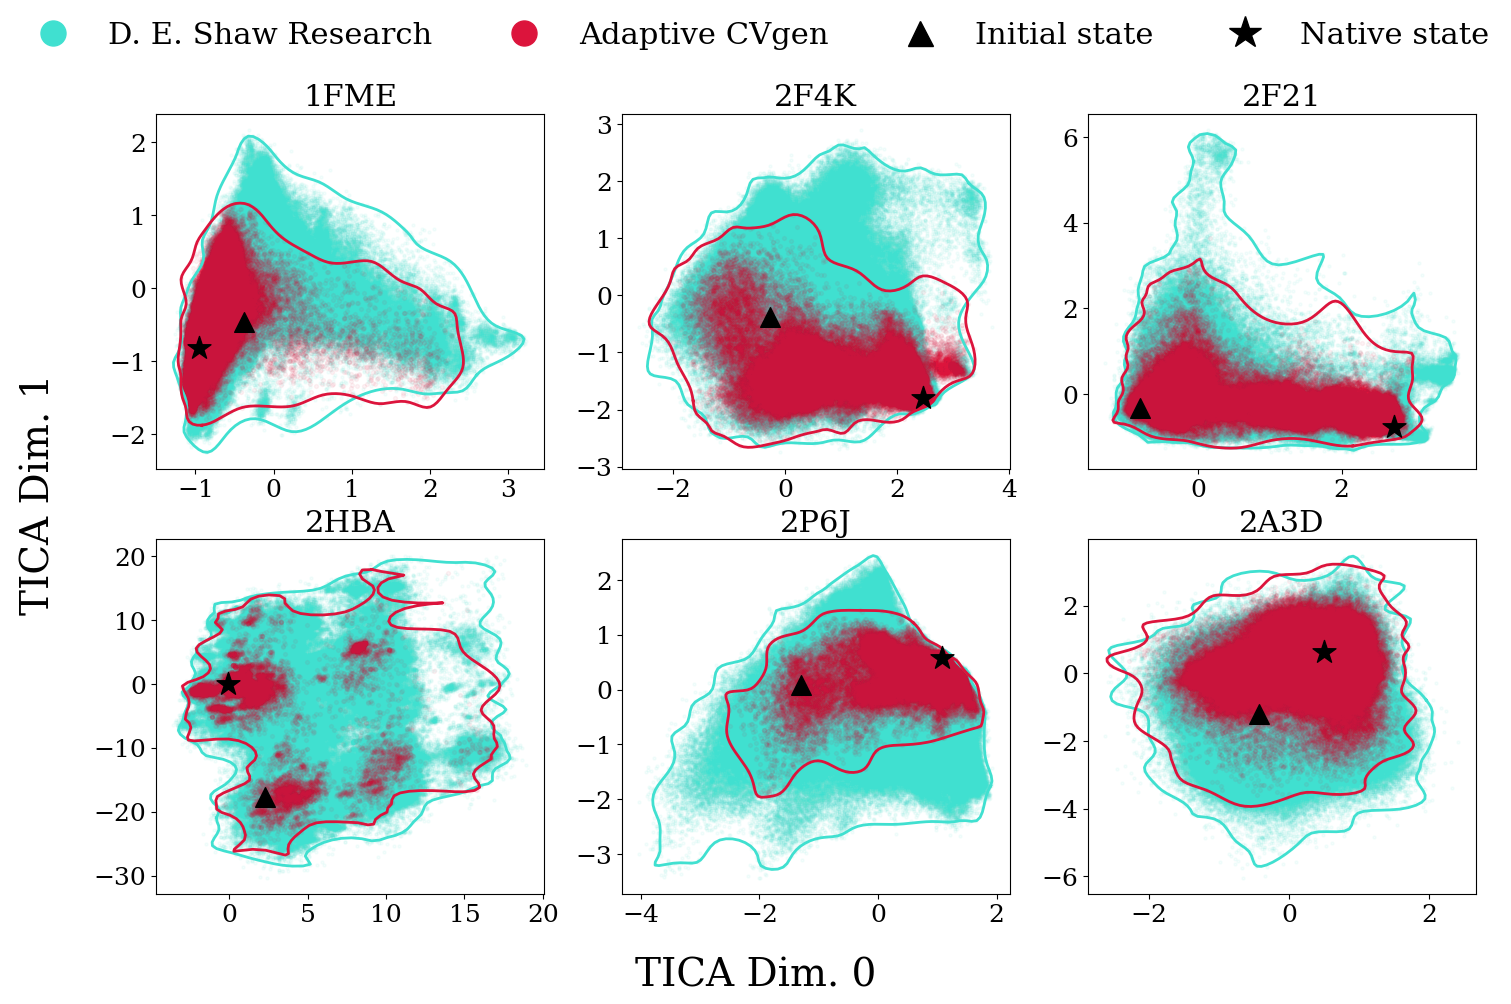

In [19]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams["font.family"] = "serif"
# Create a grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Iterate over each file
for i, pro in enumerate(protein_lst):
    axs[i // 3, i % 3].scatter(all_TICS[i][:aton_lens[i],0], all_TICS[i][:aton_lens[i],1], label='D. E. Shaw Research', c='Turquoise', s=5, alpha=0.05)
    # 绘制平滑的轮廓线
    axs[i // 3, i % 3].plot(smooth_points[i][0][:, 0], smooth_points[i][0][:, 1], color='Turquoise', linewidth=2)
    
    axs[i // 3, i % 3].scatter(all_TICS[i][aton_lens[i]:-1,0], all_TICS[i][aton_lens[i]:-1,1], label='Adaptive CVgen', c='Crimson', s=8, alpha=0.05)
    # 绘制平滑的轮廓线
    axs[i // 3, i % 3].plot(smooth_points[i][1][:, 0], smooth_points[i][1][:, 1], color='Crimson', linewidth=2)
    
    # 绘制初始构象点
    axs[i // 3, i % 3].scatter(all_TICS[i][aton_lens[i]+1,0], all_TICS[i][aton_lens[i]+1,1], label='Initial state', c='black', s=200, marker='^', zorder=3)
    # 绘制天然态点
    axs[i // 3, i % 3].scatter(all_TICS[i][-1,0], all_TICS[i][-1,1], label='Native state', c='black', s=300, marker='*', zorder=3)
        
    axs[i // 3, i % 3].set_title(pro.upper(), fontsize=22)
    # 设置刻度值的大小
    axs[i // 3, i % 3].tick_params(axis='both', labelsize=18)
    
    # # 调整每个子图的纵坐标范围以免图例遮盖数据点
    # ylims = axs[i // 3, i % 3].get_ylim()
    # new_ylims = (ylims[0], ylims[1] + (ylims[1] - ylims[0]) * 0.15)  # 在原有基础上增加15%的空间
    # axs[i // 3, i % 3].set_ylim(new_ylims)
    
    # # 创建图例
    # legend = axs[i // 3, i % 3].legend(loc='upper left', framealpha=0.3)
    # # 放大图例的marker尺寸
    # for handle in legend.legendHandles:
    #     handle.set_sizes([30])  # 调整图例marker的尺寸
    # 创建自定义图例
    legend_cvgen = mlines.Line2D([], [], color='Turquoise', marker='o', linestyle='None', markersize=18, label='D. E. Shaw Research', alpha=1.0)
    legend_least = mlines.Line2D([], [], color='Crimson', marker='o', linestyle='None', markersize=18, label='Adaptive CVgen', alpha=1.0)
    legend_initial = mlines.Line2D([], [], color='black', marker='^', linestyle='None', markersize=18, label='Initial state', alpha=1.0)
    legend_native = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=24, label='Native state', alpha=1.0)
    # axs[i // 3, i % 3].legend(handles=[legend_cvgen, legend_least, legend_native], loc='upper left', framealpha=0.0)
        
# Create a single legend at the top center of the figure
# fig.legend(handles=[legend_cvgen, legend_least, legend_native], loc='upper center', framealpha=0.0, ncol=3, fontsize=20)
fig.legend(handles=[legend_cvgen, legend_least, legend_initial, legend_native], loc='upper center', bbox_to_anchor=(0.5, 1.0), framealpha=0.0, ncol=4, fontsize=22)

fig.supxlabel('TICA Dim. 0', fontsize=28, y=-0.0)
fig.supylabel('TICA Dim. 1', fontsize=28, x= 0.01)

# Adjust the spacing between subplots
plt.subplots_adjust(bottom=0.1, top=0.88, left=0.1, right=0.98)  # Adjust the top of the subplots to make room for the legend and labels
    
# Show the plot
# plt.show()

plt.savefig('compare_DEshaw_cutoff'+str(cutoff)+'.jpg', dpi=500)
plt.savefig('compare_DEshaw_cutoff'+str(cutoff)+'.png', dpi=100)

In [13]:
np.argmax(all_TICS[3][aton_lens[3]:-1,1])

130941

In [14]:
import mdtraj as md
traj = md.load_dcd('./data/compare_DEshaw/2hba/history.dcd','./data/compare_DEshaw/2hba/p.pdb')

In [15]:
traj[130941].save_pdb('./data/compare_DEshaw/2hba/miss.pdb')

In [59]:
def feature(dirs, pdb):
    feat = pyemma.coordinates.featurizer(pdb)
    pairs = feat.pairs(feat.select_Ca())
    feat.add_contacts(pairs,threshold=0.6)
    data = pyemma.coordinates.source(dirs, features=feat)
    data_output = data.get_output()
    return data_output

In [60]:
check_pdb = md.load_pdb('./data/check.pdb')
check_pdb.save('./data/check.dcd')

check_pdb1 = md.load_pdb('./data/check1.pdb')
check_pdb1.save('./data/check1.dcd')

check_out = feature('./data/check.dcd','./data/check.pdb')
check_out1 = feature('./data/check1.dcd','./data/check1.pdb')
native_out = feature('./iTOL_plot/2hba/p.dcd','./iTOL_plot/2hba/p.pdb')

In [41]:
test = check_out[0]==check_out1[0]

In [61]:
test = check_out[0]==native_out[0]

In [62]:
np.sum(test)

692

In [39]:
687/741

0.9271255060728745

In [13]:
stride = 100
Aton_outs_reduced = []
lagtime = 1
all_tics = []
aton_lens = []

with open('./data/Aton_2hba.pkl','rb') as f:
    Aton = pickle.load(f)
reduced_outs = []
for j in range(len(Aton)):
    reduced_outs.append(Aton[j][::stride])
Aton_outs_reduced.append(reduced_outs)

tica_estimator = TICA(lagtime=lagtime, dim=2)
tica = tica_estimator.fit(Aton_outs_reduced[-1]).fetch_model()
print('TICA dimension = ', tica.output_dimension)

tmp_tics = []
length = 0
for j in Aton:
    length += len(j)
aton_lens.append(length)
for out in tqdm(Aton):
    tics = tica.transform(out)
    tmp_tics.append(tics)
for out in tqdm(AC_outs[3]):
    tics = tica.transform(out)
    tmp_tics.append(tics)
tmp_tics.append(tica.transform(check_out[0]))
all_tics.append(tmp_tics)

del Aton

TICA dimension =  2


100%|██████████| 1129/1129 [00:10<00:00, 104.28it/s]


In [25]:
all_TICS = np.concatenate(all_tics[0],axis=0)

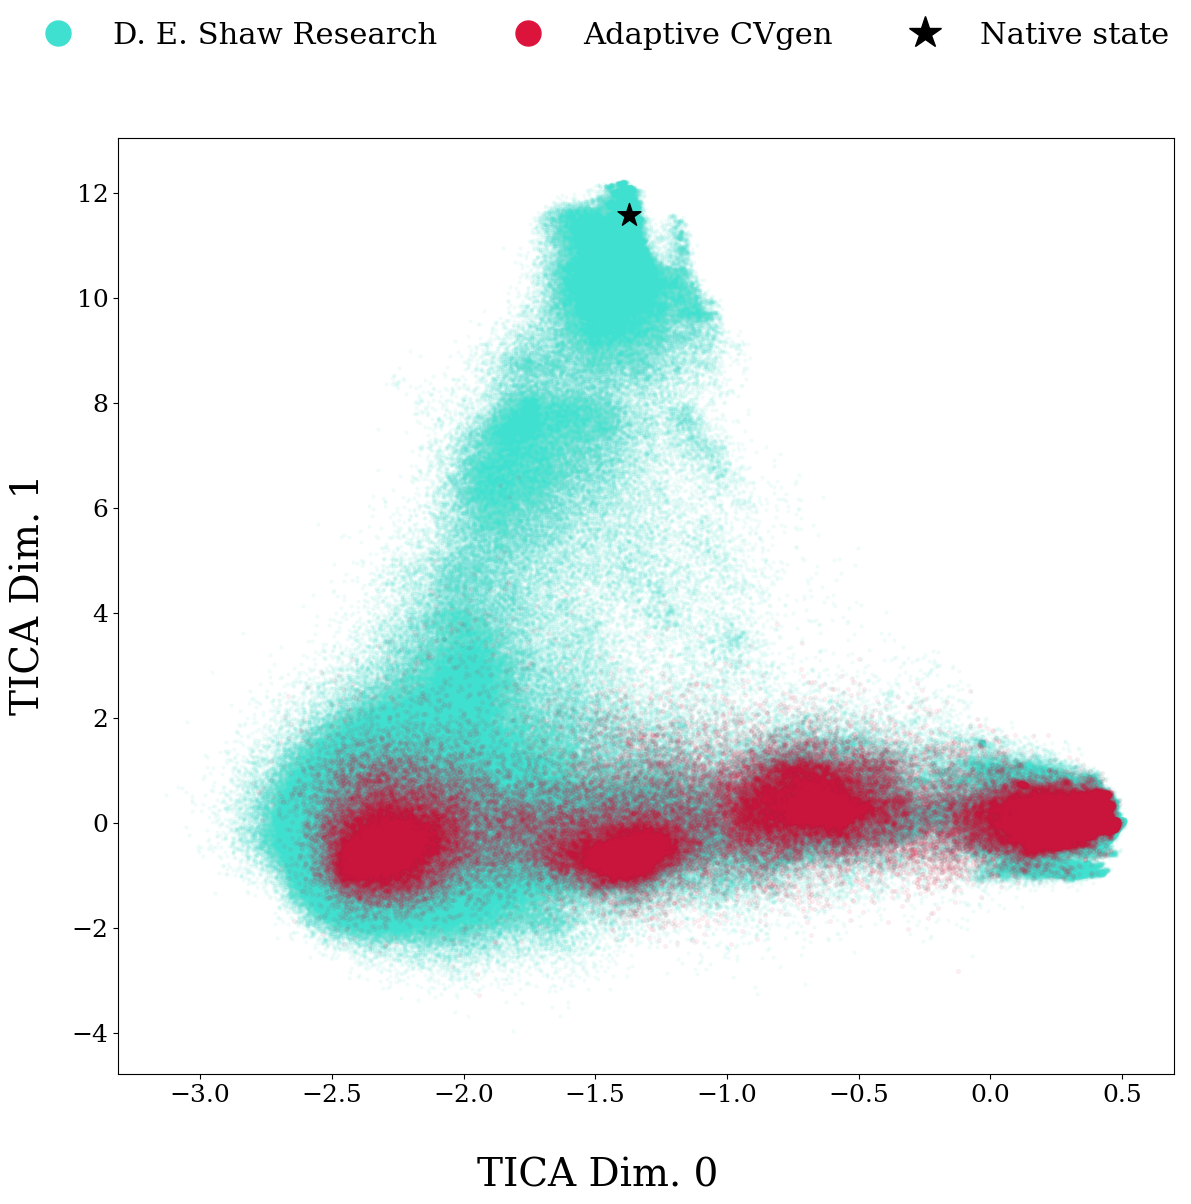

In [29]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams["font.family"] = "serif"
# Create a grid of subplots
fig, axs = plt.subplots(figsize=(12, 12))

# Iterate over each file
axs.scatter(all_TICS[:aton_lens[0],0], all_TICS[:aton_lens[0],1], label='D. E. Shaw Research', c='Turquoise', s=5, alpha=0.05)
# 绘制平滑的轮廓线
# axs[i // 3, i % 3].plot(smooth_points[i][0][:, 0], smooth_points[i][0][:, 1], color='Turquoise', linewidth=2)

axs.scatter(all_TICS[aton_lens[0]:-1,0], all_TICS[aton_lens[0]:-1,1], label='Adaptive CVgen', c='Crimson', s=8, alpha=0.05)
# 绘制平滑的轮廓线
# axs[i // 3, i % 3].plot(smooth_points[i][1][:, 0], smooth_points[i][1][:, 1], color='Crimson', linewidth=2)

# 绘制天然态点
axs.scatter(all_TICS[-1,0], all_TICS[-1,1], label='Native state', c='black', s=300, marker='*', zorder=3)
    
# 设置刻度值的大小
axs.tick_params(axis='both', labelsize=18)

# # 调整每个子图的纵坐标范围以免图例遮盖数据点
# ylims = axs[i // 3, i % 3].get_ylim()
# new_ylims = (ylims[0], ylims[1] + (ylims[1] - ylims[0]) * 0.15)  # 在原有基础上增加15%的空间
# axs[i // 3, i % 3].set_ylim(new_ylims)

# # 创建图例
# legend = axs[i // 3, i % 3].legend(loc='upper left', framealpha=0.3)
# # 放大图例的marker尺寸
# for handle in legend.legendHandles:
#     handle.set_sizes([30])  # 调整图例marker的尺寸
# 创建自定义图例
legend_cvgen = mlines.Line2D([], [], color='Turquoise', marker='o', linestyle='None', markersize=18, label='D. E. Shaw Research', alpha=1.0)
legend_least = mlines.Line2D([], [], color='Crimson', marker='o', linestyle='None', markersize=18, label='Adaptive CVgen', alpha=1.0)
legend_native = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=24, label='Native state', alpha=1.0)
# axs[i // 3, i % 3].legend(handles=[legend_cvgen, legend_least, legend_native], loc='upper left', framealpha=0.0)
        
# Create a single legend at the top center of the figure
# fig.legend(handles=[legend_cvgen, legend_least, legend_native], loc='upper center', framealpha=0.0, ncol=3, fontsize=20)
fig.legend(handles=[legend_cvgen, legend_least, legend_native], loc='upper center', bbox_to_anchor=(0.5, 1.0), framealpha=0.0, ncol=3, fontsize=22)

fig.supxlabel('TICA Dim. 0', fontsize=28, y=-0.0)
fig.supylabel('TICA Dim. 1', fontsize=28, x= 0.01)

# Adjust the spacing between subplots
plt.subplots_adjust(bottom=0.1, top=0.88, left=0.1, right=0.98)  # Adjust the top of the subplots to make room for the legend and labels
    
# Show the plot
plt.show()

# plt.savefig('compare_DEshaw.jpg', dpi=500)